In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset, load_dataset, DatasetDict
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import tensorflow as tf
import numpy as np
sns.set()

In [2]:
df = pd.read_csv('/kaggle/input/labeled-data/labeled_data.csv')
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [3]:
df.shape

(24783, 7)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          24783 non-null  int64 
 1   count               24783 non-null  int64 
 2   hate_speech         24783 non-null  int64 
 3   offensive_language  24783 non-null  int64 
 4   neither             24783 non-null  int64 
 5   class               24783 non-null  int64 
 6   tweet               24783 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.3+ MB


In [5]:
df.isnull().sum()

Unnamed: 0            0
count                 0
hate_speech           0
offensive_language    0
neither               0
class                 0
tweet                 0
dtype: int64

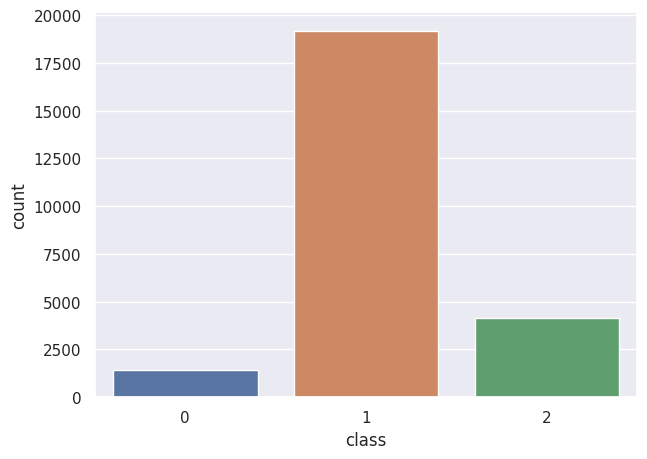

In [6]:
plt.figure(figsize = (7, 5))
sns.countplot(data = df, x = 'class')
plt.show()

In [7]:
df['tweet'] = df['tweet'].str.replace('@[A-Za-z0-9]+\s?', '', regex = True)

In [8]:
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT : As a woman you shouldn't complain abo...
1,1,3,0,3,0,1,!!!!! RT : boy dats cold...tyga dwn bad for cu...
2,2,3,0,3,0,1,!!!!!!! RT Dawg!!!! RT : You ever fuck a bitch...
3,3,3,0,2,1,1,!!!!!!!!! RT _G_Anderson: _based she look like...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT : The shit you hear about me ...


In [9]:
ds = Dataset.from_pandas(df)
ds

Dataset({
    features: ['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither', 'class', 'tweet'],
    num_rows: 24783
})

In [10]:
train_test_valid = ds.train_test_split()
test_valid = train_test_valid['test'].train_test_split()
train_test_valid_dataset = DatasetDict({
    'train': train_test_valid['train'],
    'test': test_valid['train'],
    'valid': test_valid['test']
})

dataset = train_test_valid_dataset.remove_columns(['hate_speech', 'offensive_language', 'neither', 'Unnamed: 0', 'count'])
dataset

DatasetDict({
    train: Dataset({
        features: ['class', 'tweet'],
        num_rows: 18587
    })
    test: Dataset({
        features: ['class', 'tweet'],
        num_rows: 4647
    })
    valid: Dataset({
        features: ['class', 'tweet'],
        num_rows: 1549
    })
})

In [11]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [12]:
text = 'Just checking tokenization'
output = tokenizer(text)
output

{'input_ids': [101, 2066, 9444, 22559, 2734, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1]}

In [13]:
tokens = tokenizer.convert_ids_to_tokens(output['input_ids'])
tokens

['[CLS]', 'Just', 'checking', 'token', '##ization', '[SEP]']

In [14]:
print(f'Tokenized text: {tokenizer.convert_tokens_to_string(tokens)}')

Tokenized text: [CLS] Just checking tokenization [SEP]


In [15]:
print(f'Vocab size is : {tokenizer.vocab_size}')
print(f'Model max length is : {tokenizer.model_max_length}')
print(f'Model input names are : {tokenizer.model_input_names}')

Vocab size is : 28996
Model max length is : 512
Model input names are : ['input_ids', 'token_type_ids', 'attention_mask']


In [16]:
def tokenize_function(train_dataset):
    return tokenizer(train_dataset['tweet'], padding = 'max_length', truncation = True)

In [17]:
tokenized_data = dataset.map(tokenize_function, batched = True)

Map:   0%|          | 0/18587 [00:00<?, ? examples/s]

Map:   0%|          | 0/4647 [00:00<?, ? examples/s]

Map:   0%|          | 0/1549 [00:00<?, ? examples/s]

In [18]:
tokenized_data

DatasetDict({
    train: Dataset({
        features: ['class', 'tweet', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 18587
    })
    test: Dataset({
        features: ['class', 'tweet', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 4647
    })
    valid: Dataset({
        features: ['class', 'tweet', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1549
    })
})

In [19]:
train_dataset = tokenized_data['train']
test_dataset = tokenized_data['test']
eval_dataset = tokenized_data['valid']

In [20]:
train_dataset

Dataset({
    features: ['class', 'tweet', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 18587
})

In [21]:
train_set = train_dataset.remove_columns(['tweet']).with_format('tensorflow')
val_set = eval_dataset.remove_columns(['tweet']).with_format('tensorflow')
test_set = test_dataset.remove_columns(['tweet']).with_format('tensorflow')

In [22]:
train_features = {x: train_set[x] for x in tokenizer.model_input_names}
train_set_for_final_model = tf.data.Dataset.from_tensor_slices((train_features, train_set['class']))
train_set_for_final_model = train_set_for_final_model.shuffle(len(train_set)).batch(8)

In [23]:
train_set_for_final_model

<_BatchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 512), dtype=tf.int64, name=None), 'token_type_ids': TensorSpec(shape=(None, 512), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, 512), dtype=tf.int64, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [24]:
test_features = {x: test_set[x] for x in tokenizer.model_input_names}
test_set_for_final_model = tf.data.Dataset.from_tensor_slices((test_features, test_set['class']))
test_set_for_final_model = test_set_for_final_model.shuffle(len(test_set)).batch(8)

In [25]:
test_features

{'input_ids': <tf.Tensor: shape=(4647, 512), dtype=int64, numpy=
 array([[ 101, 8147, 2959, ...,    0,    0,    0],
        [ 101,  155, 1942, ...,    0,    0,    0],
        [ 101,  155, 1942, ...,    0,    0,    0],
        ...,
        [ 101,  155, 1942, ...,    0,    0,    0],
        [ 101,  168, 1572, ...,    0,    0,    0],
        [ 101, 4299, 1567, ...,    0,    0,    0]])>,
 'token_type_ids': <tf.Tensor: shape=(4647, 512), dtype=int64, numpy=
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])>,
 'attention_mask': <tf.Tensor: shape=(4647, 512), dtype=int64, numpy=
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]])>}

In [26]:
val_features = {x: val_set[x] for x in tokenizer.model_input_names}
val_set_for_final_model = tf.data.Dataset.from_tensor_slices((val_features, val_set['class']))
val_set_for_final_model = val_set_for_final_model.shuffle(len(val_set)).batch(8)

In [27]:
model = TFAutoModelForSequenceClassification.from_pretrained('bert-base-cased', num_labels = 3)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 5e-5),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = tf.keras.metrics.SparseCategoricalAccuracy()
)

In [29]:
history = model.fit(train_set_for_final_model, validation_data = val_set_for_final_model, epochs = 3)

Epoch 1/3
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


I0000 00:00:1733404015.811566      77 service.cc:145] XLA service 0x7ed6c0f35930 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733404015.811643      77 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1733404015.978904      77 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2324/2324 [==============================] - 1425s 585ms/step - loss: 0.3158 - sparse_categorical_accuracy: 0.8973 - val_loss: 0.2827 - val_sparse_categorical_accuracy: 0.9116
Epoch 2/3
2324/2324 [==============================] - 1351s 581ms/step - loss: 0.3137 - sparse_categorical_accuracy: 0.8918 - val_loss: 0.3073 - val_sparse_categorical_accuracy: 0.9090
Epoch 3/3
2324/2324 [==============================] - 1351s 581ms/step - loss: 0.4033 - sparse_categorical_accuracy: 0.8398 - val_loss: 0.5805 - val_sparse_categorical_accuracy: 0.7676


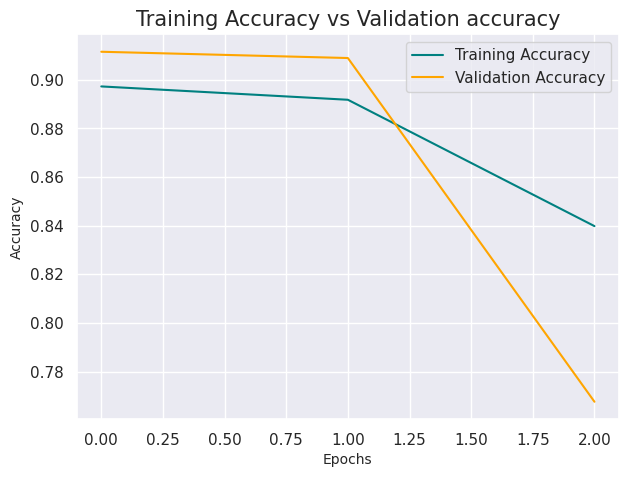

In [31]:
plt.figure(figsize = (7, 5))
plt.plot(history.history['sparse_categorical_accuracy'], label = 'Training Accuracy', color = 'teal')
plt.plot(history.history['val_sparse_categorical_accuracy'], label = 'Validation Accuracy', color = 'orange')
plt.title('Training Accuracy vs Validation accuracy', fontsize = 15)
plt.xlabel('Epochs', fontsize = 10)
plt.ylabel('Accuracy', fontsize = 10)
plt.legend()
plt.show()

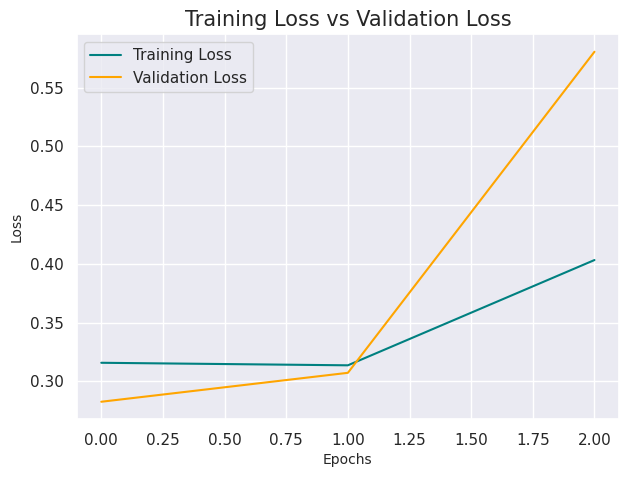

In [32]:
plt.figure(figsize = (7, 5))
plt.plot(history.history['loss'], label = 'Training Loss', color = 'teal')
plt.plot(history.history['val_loss'], label = 'Validation Loss', color = 'orange')
plt.title('Training Loss vs Validation Loss', fontsize = 15)
plt.xlabel('Epochs', fontsize = 10)
plt.ylabel('Loss', fontsize = 10)
plt.legend()
plt.show()

In [33]:
model.evaluate(test_set_for_final_model)

581/581 [==============================] - 117s 201ms/step - loss: 0.5646 - sparse_categorical_accuracy: 0.7721


[0.5646321773529053, 0.7721110582351685]

In [38]:
predict_score_and_class_dict = {
    0: 'Hate Speech',
    1: 'Offensive Language',
    2: 'Neither'
}
preds = model(tokenizer(["He is useless", "I don't know why he came to our neighborhood", "That guy sucks", "He is a good person"],
                      return_tensors = "tf", padding = True, truncation = True))['logits']
print(preds)
class_preds = np.argmax(preds, axis = 1)
for pred in class_preds:
    print(predict_score_and_class_dict[pred])

tf.Tensor(
[[-1.6002507   1.163477    0.1662514 ]
 [-1.6002544   1.1634777   0.16625063]
 [-1.6002679   1.1634797   0.16624828]
 [-1.6002605   1.1634786   0.16624963]], shape=(4, 3), dtype=float32)
Offensive Language
Offensive Language
Offensive Language
Offensive Language
